In [1]:
import pandas as pd
import base
import os
import pickle
from keras.models import load_model
import numpy as np

2024-01-05 06:27:52.832322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 06:27:52.869543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 06:27:52.869582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 06:27:52.870593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 06:27:52.876975: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [3]:
from keras.models import load_model
loaded_negmodel = load_model("Data/03_model/neg/neg_class_model_3")
    
with open('Data/03_model/neg/negmodelcolumn_all.pkl', 'rb') as file:
    loaded_negcolumns = pickle.load(file)
        
with open('Data/03_model/neg/neg_replacement_dict_all.pkl', 'rb') as file:
    replacement_dict = pickle.load(file)

In [4]:
df_neg = pd.read_csv('Data/02_basedata/neg/df_neg.csv')[['Ontology','Metabolitename','MSMSspectrum','AverageMz']].reset_index().rename(columns={'index':'ID'})

In [5]:
df_rep = pd.DataFrame(list(replacement_dict.items()), columns=['Ontology', 'Value'])

モデルに入っていないが、データとして持っている脂質クラス

In [6]:
df_neg[~df_neg['Ontology'].isin(df_rep.Ontology.tolist())].Ontology.drop_duplicates().tolist()

['FA',
 'Others',
 'NGcGM3',
 'MLCL',
 'DGMG',
 'Cer_BDS',
 'SHex',
 'AHexCAS',
 'AHexSTS',
 'ADGGA',
 'LNAPS',
 'DGGA',
 'EtherOxPC',
 'AHexBRS',
 'MGMG',
 'DGDG',
 'DCAE',
 'SMGDG',
 'GD2',
 'GQ1b']

In [24]:
df_neg2 = df_neg[df_neg['Ontology'].isin(['EtherOxPC','EtherPC'])]

In [51]:
df_neg_exp_ = base.spectrum_tidy_f(df_neg2)
df_neg_neuloss_ = base.neutralloss_tidy_f(df_neg2)
df_neg_data = base.spectrum_neutralloss_table_f(df_neg_exp_, df_neg_neuloss_)

df_neg_data['div2'] = df_neg_data['AverageMz'].round().astype(int) % 2
df_neg_data['modnum'] = base.cal_mod(df_neg_data['AverageMz'])

In [26]:
columns_to_drop = ['ID', 'AverageMz', 'Metabolitename', 'Ontology']
df_neg_data.columns = df_neg_data.columns.astype('str')
X1_test = df_neg_data[loaded_negcolumns]
y_pred_test = loaded_negmodel.predict(X1_test)

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 6ms/step


In [27]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_replacement_dict_reversed = pd.DataFrame(columns=['replaced_num', 'replaced_name'])
for replacement, original in replacement_dict_reversed.items():
    df_replacement_dict_reversed = pd.concat([df_replacement_dict_reversed, pd.DataFrame({'replaced_num': [replacement], 'replaced_name': [original]})], ignore_index=True)

In [67]:
df_pred_test = pd.DataFrame(y_pred_test).rename(columns=df_replacement_dict_reversed['replaced_name'])
df_pred_test.index = df_neg2.ID

y_pred_test_max = np.argmax(y_pred_test, axis=1)
y_pred_test_max_ = np.vectorize(base.apply_replacement)(y_pred_test_max, replacement_dict_reversed)

df_pred_test['pred_1class'] = y_pred_test_max_
df_pred_test['pred_class'] = df_pred_test.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_pred_test['pred_number'] = df_pred_test['pred_class'].apply(lambda x: len(x.split(',')))

In [68]:
df_pred_result = df_pred_test[['pred_1class','pred_class','pred_number']].reset_index()

In [69]:
df_pred_result.merge(df_neg2[['ID','Metabolitename','Ontology']],how='inner',on='ID').query('Ontology == "EtherOxPC"')

,ID,pred_1class,pred_class,pred_number,Metabolitename,Ontology
262,5366,EtherPC,EtherPC:1.0,1,PC O-33:1;1O|PC O-18:0_15:1;1O,EtherOxPC
387,8210,EtherPC,EtherPC:1.0,1,PC O-31:1;1O|PC O-16:0_15:1;1O,EtherOxPC
399,8492,EtherPC,EtherPC:1.0,1,PC O-33:1;1O|PC O-18:0_15:1;1O,EtherOxPC


In [83]:
df_neg_data_posint.columns

Index([   70,    71,    72,    73,    74,    75,    76,    77,    78,    79,
       ...
       -1241, -1242, -1243, -1244, -1245, -1246, -1247, -1248, -1249, -1250],
      dtype='object', length=2422)

In [93]:
df_neg_data_posint = df_neg_data.set_index('ID').drop(columns=['AverageMz', 'Metabolitename', 'Ontology', 'div2', 'modnum', 'MSMSspectrum'])
df_neg_data_posint = pd.DataFrame(df_neg_data_posint.T).reset_index().query('index > 0').set_index('index').T

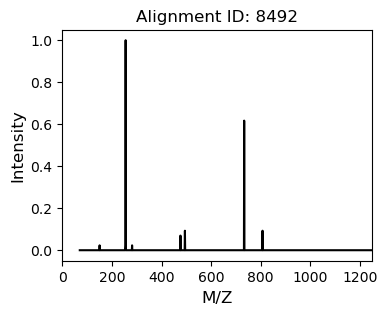

In [94]:
import matplotlib.pyplot as plt

Alignmnentid = 8492
df1= pd.DataFrame(df_neg_data_posint.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/neg/data_id8492_etheroxpc.svg', format='svg', bbox_inches='tight')

plt.show()

In [95]:
df_neg.query('ID == 8492')

,ID,Ontology,Metabolitename,MSMSspectrum,AverageMz
8492,8492,EtherOxPC,PC O-33:1;1O|PC O-18:0_15:1;1O,150.45016:12 254.44296:12 255.23:517 281.23108...,806.591


In [96]:
Alignmnentid = 8492

element_list = df_neg[df_neg['ID'] == Alignmnentid]['MSMSspectrum'].str.split(' ')

mz_list = []
int_list = []

for element in element_list:
    for i in element:
        i_div = i.split(':')
        mz = i_div[0]
        int_val = i_div[1]

        mz_list.append(mz)
        int_list.append(int_val)

df = pd.DataFrame(list(zip(mz_list, int_list))).rename(columns={0:'mz',1:'int'}).astype(float)
df#.query('int > ')

,mz,int
0,150.45016,12.0
1,254.44296,12.0
2,255.23000,517.0
3,281.23108,12.0
4,476.30865,36.0
5,494.32233,48.0
6,732.55090,319.0
7,806.56995,24.0
8,806.58850,24.0


EtherPC

In [104]:
df_neg2[df_neg2['Ontology'] == "EtherPC"].query('Metabolitename == "PC O-32:1|PC O-16:1_16:0"')

,ID,Ontology,Metabolitename,MSMSspectrum,AverageMz
186,186,EtherPC,PC O-32:1|PC O-16:1_16:0,214.05402:10 224.06561:36 227.20271:36 236.177...,776.57532
923,923,EtherPC,PC O-32:1|PC O-16:1_16:0,78.95854:36 143.0993:24 152.99664:36 156.36185...,776.58258
1426,1426,EtherPC,PC O-32:1|PC O-16:1_16:0,119.03457:12 168.04399:24 224.06296:24 227.200...,776.58130
4178,4178,EtherPC,PC O-32:1|PC O-16:1_16:0,156.45561:5 224.05797:6 239.21527:6 239.2283:1...,776.58679
4988,4988,EtherPC,PC O-32:1|PC O-16:1_16:0,224.05461:12 227.19569:36 255.22812:999 329.23...,776.58112
5701,5701,EtherPC,PC O-32:1|PC O-16:1_16:0,163.64197:10 168.03917:24 224.05898:12 224.065...,776.58276
6029,6029,EtherPC,PC O-32:1|PC O-16:1_16:0,78.95984:18 168.03217:6 168.04308:18 224.06918...,776.58258
7282,7282,EtherPC,PC O-32:1|PC O-16:1_16:0,168.04744:24 224.0731:24 237.21976:12 253.2183...,776.58215
7454,7454,EtherPC,PC O-32:1|PC O-16:1_16:0,168.0412:7 217.52303:1 224.06915:13 227.20618:...,776.57971
7677,7677,EtherPC,PC O-32:1|PC O-16:1_16:0,168.04317:12 188.37491:12 224.06342:12 255.229...,776.57654


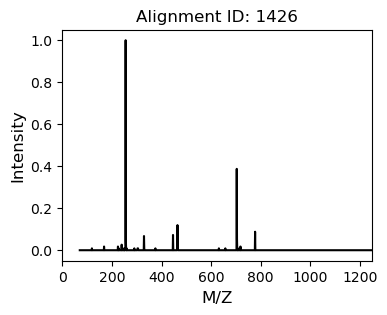

In [105]:
import matplotlib.pyplot as plt

Alignmnentid = 1426
df1= pd.DataFrame(df_neg_data_posint.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/neg/data_id4173_etherpc.svg', format='svg', bbox_inches='tight')
plt.show()

In [109]:
df1[df1['exp'] != 0]

,mz,exp
49,119.0,0.008804
98,168.0,0.017608
154,224.0,0.017608
157,227.0,0.008804
169,239.0,0.026412
179,249.0,0.008804
181,251.0,0.008804
184,254.0,0.017608
185,255.0,1.000000
186,256.0,0.044021


In [110]:
df_negx = df_neg[df_neg['Ontology'].isin(['EtherPC','EtherOxPC'])]
df_negx['modnum'] = base.cal_mod(df_negx['AverageMz'])

/tmp/ipykernel_66922/2488287015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negx['modnum'] = base.cal_mod(df_negx['AverageMz'])


/tmp/ipykernel_66922/3716260937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negx.loc[:,'OntologyCode'] = pd.Categorical(df_negx.loc[:,'Ontology']).codes


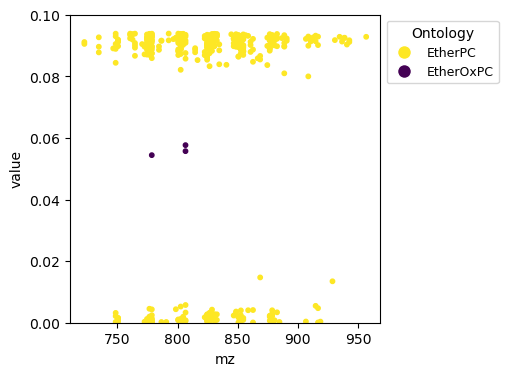

In [111]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

df_negx.loc[:,'OntologyCode'] = pd.Categorical(df_negx.loc[:,'Ontology']).codes
scatter = plt.scatter(df_negx['AverageMz'], df_negx['modnum'], c=df_negx['OntologyCode'], cmap='viridis', s=10)

plt.xlabel('mz')
plt.ylabel('value')
plt.ylim(0, 0.1)

legend_labels = df_negx['Ontology'].unique()
legend_labels_numeric = df_negx['Ontology'].astype('category').cat.codes.unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in legend_labels_numeric]

plt.legend(legend_handles, legend_labels, title='Ontology', loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

plt.savefig('Data/svg/model/result/neg/o-value_etherpc_dist.svg', format='svg', bbox_inches='tight')
